Saving Itarare.xlsx to Itarare.xlsx
Colunas detectadas e normalizadas:
['municipio', 'ano', 'mes', 'chuva', 'tmax', 'tmin', 'tmed']
Coluna ano detectada: ano
Coluna mês detectada: mes
Coluna chuva detectada: chuva


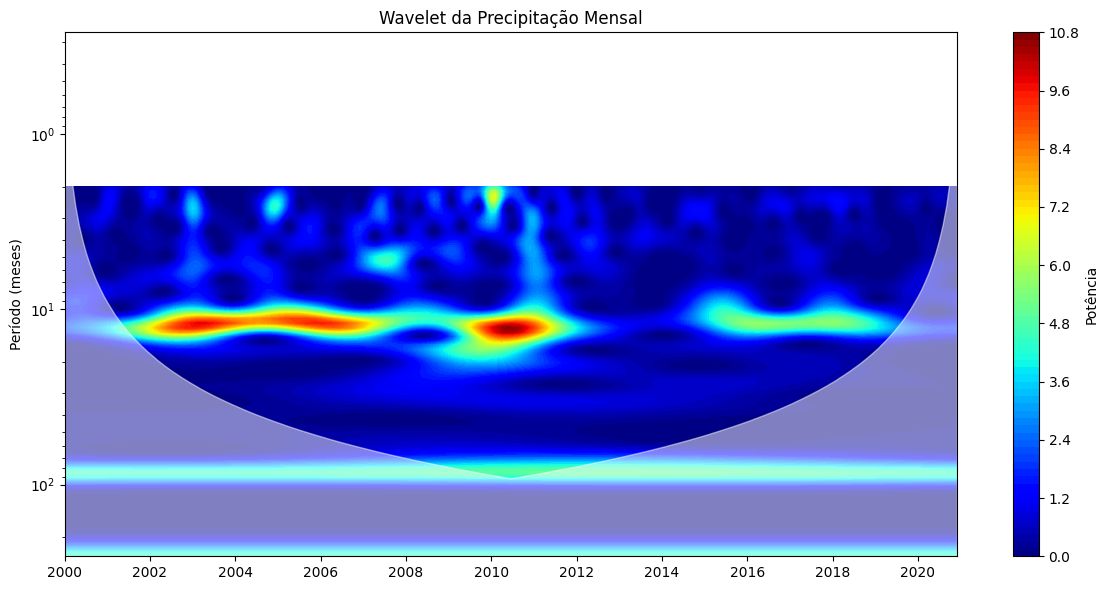

In [ ]:
# Etapa 1: Instalar bibliotecas necessárias
!pip install pycwt openpyxl unidecode

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import pycwt as wavelet
from pycwt.helpers import find
from unidecode import unidecode

# Etapa 2: Upload do arquivo Excel
uploaded = files.upload()
arquivo = next(iter(uploaded))

# Etapa 3: Leitura da planilha
df = pd.read_excel(arquivo)

# Etapa 4: Padronizar nomes das colunas
df.columns = [unidecode(col).strip().lower().replace(" ", "_") for col in df.columns]
print("Colunas detectadas e normalizadas:")
print(df.columns.tolist())

# Etapa 5: Identificar colunas relevantes
possiveis_col_ano = [col for col in df.columns if "ano" in col]
possiveis_col_mes = [col for col in df.columns if "mes" in col]
possiveis_col_chuva = [col for col in df.columns if "chuva" in col or "precip" in col]

if not (possiveis_col_ano and possiveis_col_mes and possiveis_col_chuva):
    raise ValueError("Não foi possível identificar as colunas de ano, mês e chuva.")

col_ano = possiveis_col_ano[0]
col_mes = possiveis_col_mes[0]
col_chuva = possiveis_col_chuva[0]

# Verificar quais colunas foram identificadas
print(f"Coluna ano detectada: {col_ano}")
print(f"Coluna mês detectada: {col_mes}")
print(f"Coluna chuva detectada: {col_chuva}")

# Verificar valores nulos antes de tentar criar a data
if df[[col_ano, col_mes]].isnull().any().any():
    raise ValueError("Existem valores nulos nas colunas de ano ou mês.")

# Garantir que ano e mês estão como inteiros
df[col_ano] = pd.to_numeric(df[col_ano], errors='coerce').astype('Int64')
df[col_mes] = pd.to_numeric(df[col_mes], errors='coerce').astype('Int64')

# Verificar novamente se agora existem valores nulos
if df[[col_ano, col_mes]].isnull().any().any():
    raise ValueError("Ano ou mês contém valores inválidos após conversão para inteiro.")

# Criar a coluna de data (agora com segurança)
df["data"] = pd.to_datetime(dict(year=df[col_ano], month=df[col_mes], day=1), errors="coerce")
serie = df.sort_values("data").reset_index(drop=True)

# Etapa 7: Verificar se há dados suficientes
if len(serie) < 24:
    print("Série muito curta para Wavelet. Pelo menos 24 meses são recomendados.")
else:
    # Normalizar a série
    t = np.arange(len(serie))
    dt = 1  # mensal
    y = serie[col_chuva].values
    y_norm = (y - np.mean(y)) / np.std(y)

    # Aplicar transformada wavelet contínua
    mother = wavelet.Morlet(6)
    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(y_norm, dt, 1/12, wavelet=mother)
    power = (np.abs(wave))**2
    period = 1 / freqs

    # Significância
    signif, fft_theor = wavelet.significance(y_norm, dt, scales, 0, 0.95, wavelet=mother)
    sig95 = power / (np.ones([1, len(serie)]) * signif[:, None])

    # Gráfico
    fig, ax = plt.subplots(figsize=(12, 6))
    T, P = np.meshgrid(serie['data'], period)
    im = ax.contourf(T, P, power, levels=100, cmap='jet')
    ax.contour(T, P, sig95, levels=[1], colors='k', linewidths=0.5)
    ax.fill_between(serie['data'], coi, period[-1], color='white', alpha=0.5)
    ax.set_yscale('log')
    ax.set_ylabel('Período (meses)')
    ax.set_title('Wavelet da Precipitação Mensal')
    ax.invert_yaxis()
    fig.colorbar(im, ax=ax, label='Potência')
    plt.tight_layout()
    plt.show()
